# Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Read CSV

In [30]:
df = pd.read_csv('wewo.csv')
df = df[df["year"] > 1]
df['playoff'] = df['playoff'].map({'N':0,'Y':1})

team_df = pd.read_csv('../data/teams.csv')
player_df = pd.read_csv('../data/players.csv')
pt_df = pd.read_csv('../data/players_teams.csv')

# Analysis

### Distribution of playoffs

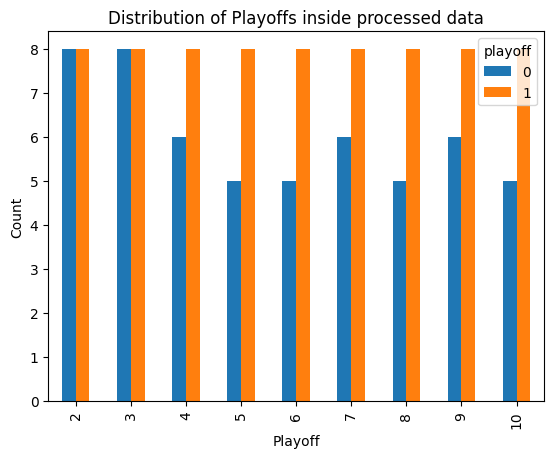

In [31]:
label_distribution = df.groupby(['year', 'playoff']).size().unstack()

label_distribution.plot(kind='bar')
plt.title('Distribution of Playoffs inside processed data')
plt.xlabel('Playoff')
plt.ylabel('Count')

plt.show()


As expected, 8 teams are always qualified for the playoffs. However, the total number of teams isn't constant.

### Playoff Distribution (according to Conference)

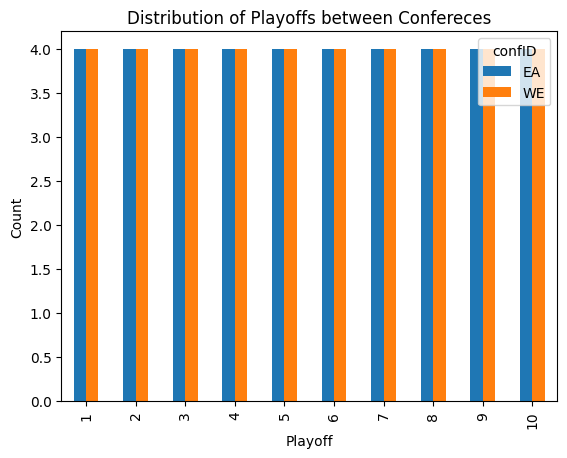

In [32]:
label_distribution = team_df[team_df["playoff"] == "Y"].groupby(['year', 'confID']).size().unstack()

label_distribution.plot(kind='bar')
plt.title('Distribution of Playoffs between Confereces')
plt.xlabel('Playoff')
plt.ylabel('Count')

plt.show()

According to WNBA's rules from some years ago, the playoff spots are equally divided between the two conferences. We can verify this with this plot. This information can be useful later on to apply some post-processing to our predictions.

### Correlation Matrix

In [33]:
tempdf = df.drop(columns='tmID', axis=1)
print(list(tempdf.columns))

['year', 'playoff', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'wr', 'GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'dq', 'Award Count', 'PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostDQ', 'PostthreeRatio', 'PostfgRatio', 'PostftRatio', 'ThreeRatio', 'fgRatio', 'ftRatio', 'coach_wr', 'coach_pwr']


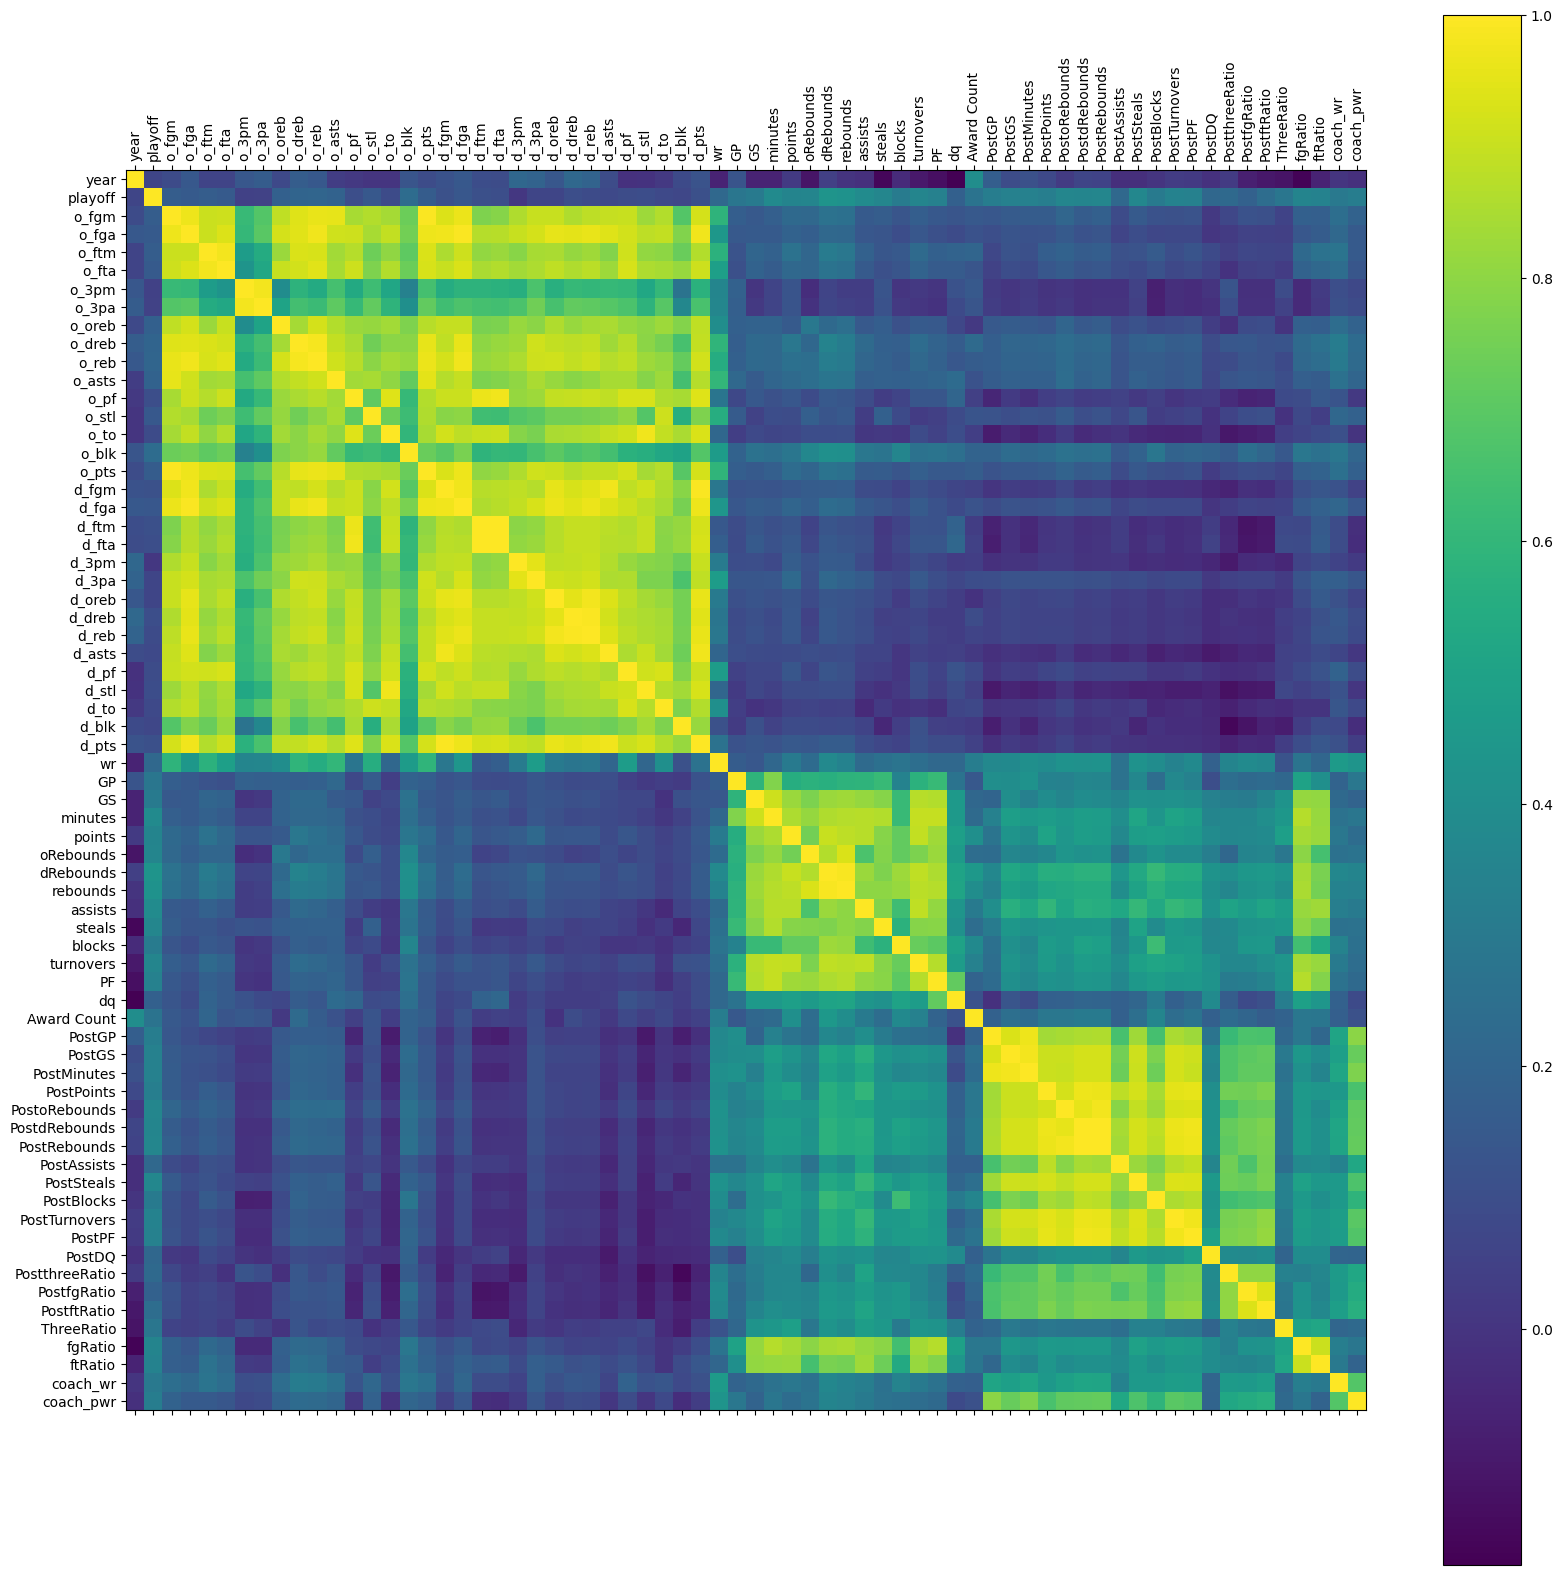

In [34]:
correlation = tempdf.corr()
plt.figure(figsize=(20, 20))
plt.matshow(correlation, fignum=1)
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation.columns)), correlation.columns)
plt.colorbar()

plt.show()

In our processed dataset, most direct correlations can be found among the team stats. This isn't surprising, since they are the least "volatile". The player stats, due to being gathered and aggregated from multiple entities, don't have a relationship that's simple enough to be expressed through parwise correlations.

### Pairplot

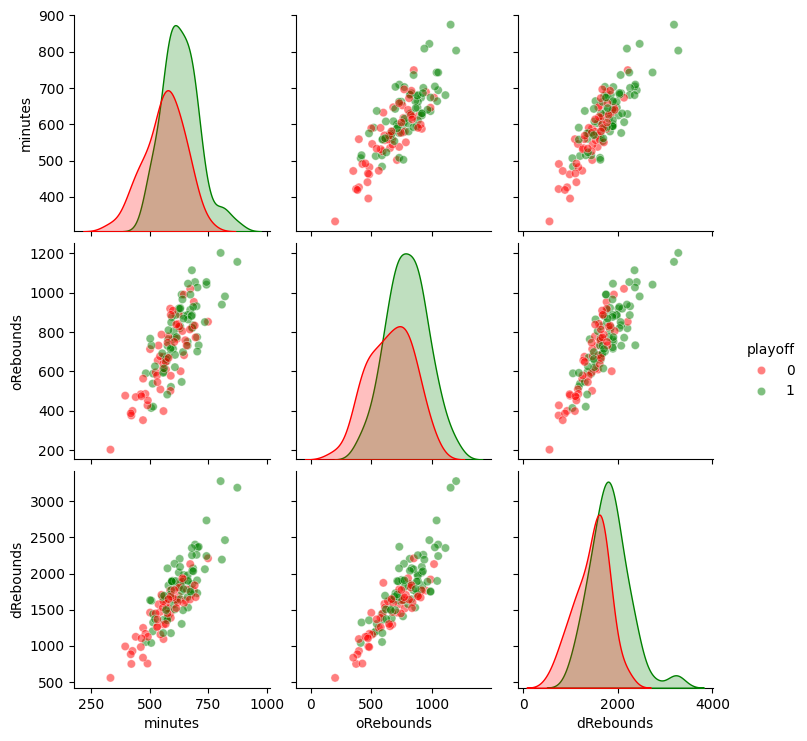

In [35]:
sample_size = df.__len__()

attributes = ["playoff", "minutes", "oRebounds", "dRebounds"]

sample = df.sample(sample_size)[attributes]

palette = {0: 'red', 1: 'green'}
sb.pairplot(sample, hue='playoff', palette=palette, plot_kws={'alpha': 0.5})

Following up on the correlation matrix, we can see that, for example, the distributions of stats in a team tend to have the same general shape. However, they can still be differentiated due to the teams that are qualified for playoffs having, on average, higher values.

### Points / Playoff

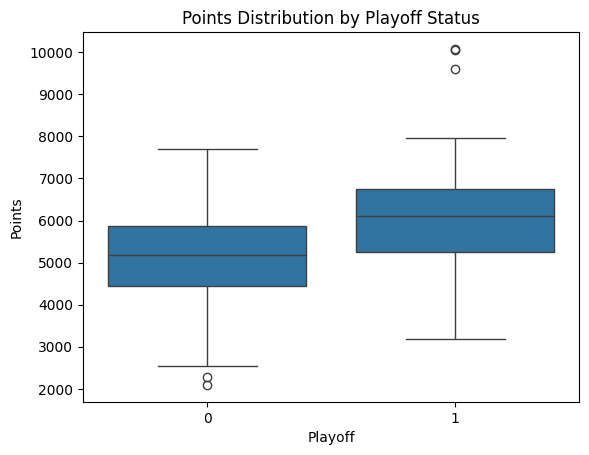

In [36]:
sb.boxplot(x='playoff', y='points', data=df)
plt.title('Points Distribution by Playoff Status')
plt.xlabel('Playoff')
plt.ylabel('Points')
plt.show()

Once again, we can see that there is a visible difference between the values present in teams that were qualified and those of teams that were not.

### Pairplot for player position

        bioID pos  firstseason  lastseason  height  weight      college  \
0  abrossv01w   F            0           0    74.0     169  Connecticut   
1  abrossv01w   F            0           0    74.0     169  Connecticut   
2  abrossv01w   F            0           0    74.0     169  Connecticut   
3  abrossv01w   F            0           0    74.0     169  Connecticut   
4  abrossv01w   F            0           0    74.0     169  Connecticut   

  collegeOther   birthDate   deathDate  ... PostBlocks  PostTurnovers  PostPF  \
0          NaN  1980-07-09  0000-00-00  ...          0              0       0   
1          NaN  1980-07-09  0000-00-00  ...          0              0       0   
2          NaN  1980-07-09  0000-00-00  ...          1              8       8   
3          NaN  1980-07-09  0000-00-00  ...          2              3       7   
4          NaN  1980-07-09  0000-00-00  ...          0              0       0   

  PostfgAttempted PostfgMade  PostftAttempted  PostftMade  Pos

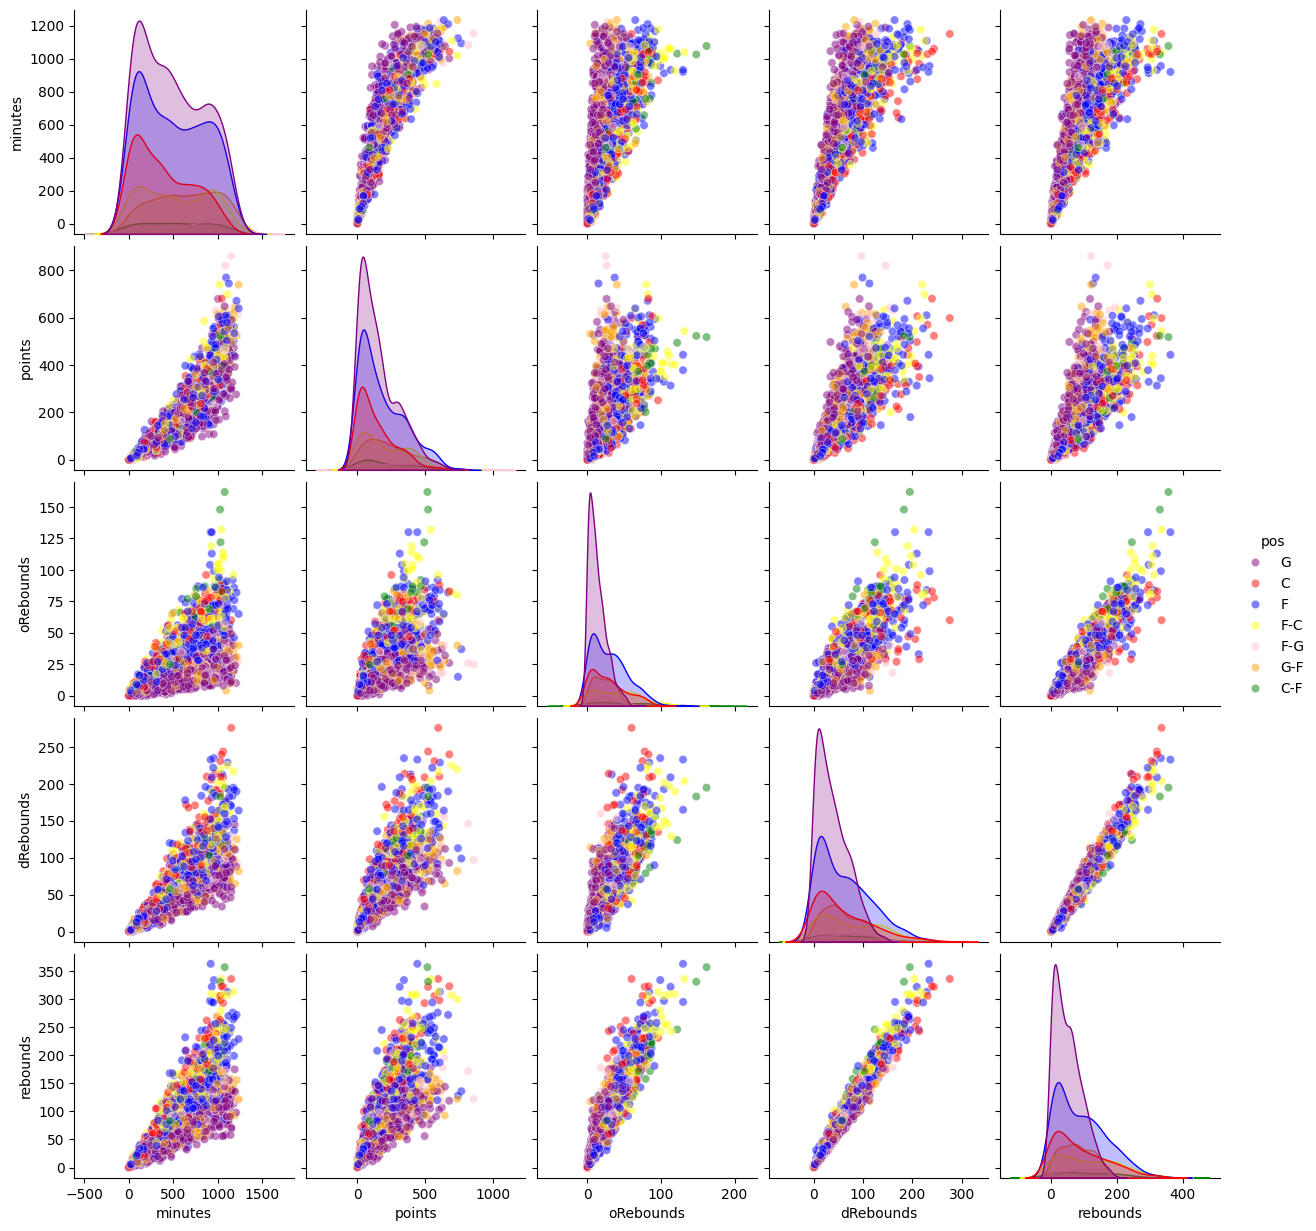

In [37]:
# Join players and player_teams
players = player_df.merge(pt_df, how='right', left_on='bioID', right_on='playerID')
print(players.head())

psample_size = players.__len__()

pattributes = [
        "pos","minutes","points","oRebounds","dRebounds",
        "rebounds", # Non Post stats
        ]
"""     
"GP","GS","assists","steals","blocks","turnovers","PF",
        "fgAttempted","fgMade","ftAttempted","ftMade","threeAttempted",
        "threeMade","dq",
        "PostGP","PostGS","PostMinutes","PostPoints","PostoRebounds",
        "PostdRebounds","PostRebounds","PostAssists","PostSteals",
        "PostBlocks","PostTurnovers","PostPF","PostfgAttempted",
        "PostfgMade","PostftAttempted","PostftMade",
        "PostthreeAttempted","PostthreeMade","PostDQ" # Post stats 
"""

psample = players.sample(psample_size)[pattributes]

ppalette = {"C": 'red', "C-F": 'green', "F": 'blue', "F-C": 'yellow', "G": 'purple', "G-F": 'orange', "F-G": 'pink'}

sb.pairplot(psample, hue='pos', palette=ppalette, plot_kws={'alpha': 0.5})

While different player positions present different values for their stats, the distribution is similar. This, along with the fact that each team will always have players in different positions, means that the differentiation of players through their position shouldn’t be a big concern.

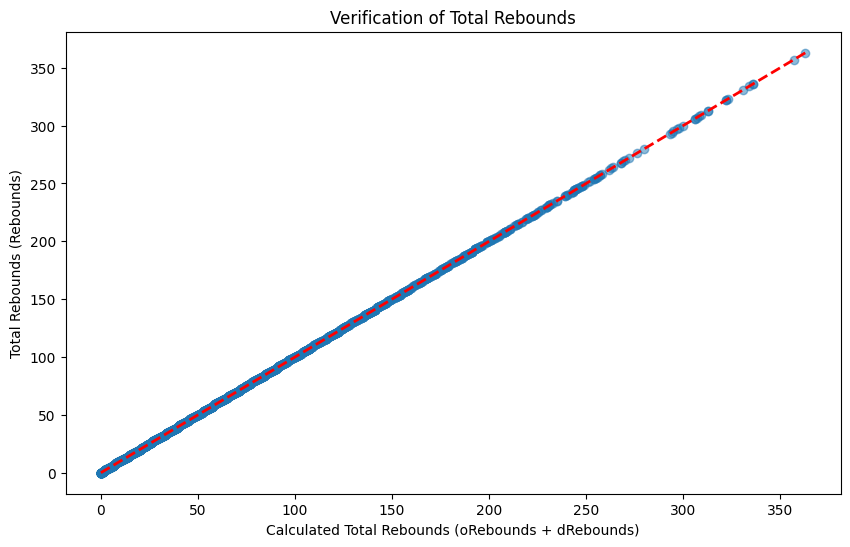

In [38]:
pt_df['total_calculated_rebounds'] = pt_df['oRebounds'] + pt_df['dRebounds']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pt_df['total_calculated_rebounds'], pt_df['rebounds'], alpha=0.5)
plt.plot([pt_df['total_calculated_rebounds'].min(), pt_df['total_calculated_rebounds'].max()],
         [pt_df['total_calculated_rebounds'].min(), pt_df['total_calculated_rebounds'].max()],
         color='red', linestyle='--', linewidth=2)  # Line y=x for reference
plt.xlabel('Calculated Total Rebounds (oRebounds + dRebounds)')
plt.ylabel('Total Rebounds (Rebounds)')
plt.title('Verification of Total Rebounds')
plt.show()

With this plot, we can validate that the values for features that exist in a generalised form, and in subdivisions (in this case, the rebounds), add up.